# PA+ER Node Ordering with a Tiny GAT
This walkthrough synthesizes preferential-attachment (PA) graphs with extra Erdős–Rényi (ER) noise edges, then trains a lightweight Graph Attention Network (GAT) to recover normalized node arrival times (ordering).

**Requirements:** `torch`, `networkx`, `scipy`, and `matplotlib`. Adjust hyperparameters or feature engineering as needed for your experiments.

In [1]:
# Core imports for plotting, graph generation, tensor modeling, and ranking statistics
import random
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import kendalltau, spearmanr

# Harmonize Matplotlib styling for all figures in the notebook
plt.style.use("seaborn-v0_8")

# Reproducible randomness across Python, NumPy, and PyTorch
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
N_NODES = 50
N_GRAPHS = 256

# Prefer GPU acceleration when it is available, otherwise fall back to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


/common/home/cx122/miniconda3/envs/graphorder/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Graph generation helpers

In [2]:
@dataclass
class GraphSample:
    """Lightweight container for the tensors derived from one synthetic graph."""

    name: str
    graph: nx.Graph
    features: torch.Tensor
    adjacency: torch.Tensor
    targets: torch.Tensor


def generate_pa_er_graph(n_nodes: int = 20, m: int = 2, er_prob: float = 0.03, seed: int | None = None):
    """Create a preferential-attachment backbone and sprinkle ER shortcut edges."""

    rng = np.random.default_rng(seed)
    G = nx.barabasi_albert_graph(n_nodes, m, seed=seed)
    # Walk all unordered node pairs and randomly add the ER edges
    for u in range(n_nodes):
        for v in range(u + 1, n_nodes):
            if not G.has_edge(u, v) and rng.random() < er_prob:
                G.add_edge(u, v)
    # Ground-truth arrival timestamps are assigned uniformly in [0, 1]
    timestamps = np.linspace(0.0, 1.0, n_nodes, dtype=np.float32)
    return G, timestamps


def build_feature_matrix(G: nx.Graph) -> torch.Tensor:
    """Engineer simple structural descriptors for every node."""

    n = G.number_of_nodes()
    degrees = np.array([G.degree(i) for i in range(n)], dtype=np.float32)
    clustering = np.array([nx.clustering(G, i) for i in range(n)], dtype=np.float32)
    pagerank_dict = nx.pagerank(G)
    pagerank = np.array([pagerank_dict[i] for i in range(n)], dtype=np.float32)
    core_dict = nx.core_number(G)
    core = np.array([core_dict[i] for i in range(n)], dtype=np.float32)
    neighbor_mean = []
    for node in range(n):
        neigh = [G.degree(nb) for nb in G.neighbors(node)]
        # Average neighbor degree summarizes local density around each node
        neighbor_mean.append(np.mean(neigh) if neigh else 0.0)
    neighbor_mean = np.array(neighbor_mean, dtype=np.float32)
    features = np.stack([degrees, clustering, pagerank, core, neighbor_mean], axis=1)
    # Normalize feature channels to zero mean / unit variance
    mean = features.mean(axis=0, keepdims=True)
    std = features.std(axis=0, keepdims=True) + 1e-6
    features = (features - mean) / std
    return torch.from_numpy(features).float()


def graph_to_sample(G: nx.Graph, timestamps: np.ndarray, name: str) -> GraphSample:
    """Convert a NetworkX graph and timestamps into PyTorch tensors."""

    n = G.number_of_nodes()
    features = build_feature_matrix(G)
    adj = nx.to_numpy_array(G, nodelist=range(n), dtype=np.float32)
    # Add self-loops so every node can attend to itself
    adj = adj + np.eye(n, dtype=np.float32)
    adj[adj > 0] = 1.0
    adjacency = torch.from_numpy(adj).float()
    targets = torch.from_numpy(timestamps).float()
    return GraphSample(name=name, graph=G.copy(), features=features, adjacency=adjacency, targets=targets)


def make_dataset(num_graphs: int = 64, n_nodes: int = 20, m: int = 2, er_prob: float = 0.03, seed_offset: int = 0) -> List[GraphSample]:
    """Batch together many independent PA+ER graphs for experimentation."""

    samples = []
    for idx in range(num_graphs):
        seed = seed_offset + idx
        G, ts = generate_pa_er_graph(n_nodes=n_nodes, m=m, er_prob=er_prob, seed=seed)
        samples.append(graph_to_sample(G, ts, name=f"graph_{idx:03d}"))
    return samples


## Build a small synthetic dataset

In [3]:
# Generate a batch of PA+ER graphs with reproducible seeds

dataset = make_dataset(num_graphs=64, n_nodes=N_NODES, m=2, er_prob=0.03, seed_offset=SEED)
train_cut = int(0.7 * len(dataset))
val_cut = int(0.85 * len(dataset))

# Deterministic 70/15/15 dataset split
train_data = dataset[:train_cut]
val_data = dataset[train_cut:val_cut]
test_data = dataset[val_cut:]

# Report dataset statistics for a quick sanity check
print(f"Graphs: train={len(train_data)}, val={len(val_data)}, test={len(test_data)}")
print(f"Feature shape: {train_data[0].features.shape}, nodes per graph = {train_data[0].graph.number_of_nodes()}")


Graphs: train=44, val=10, test=10
Feature shape: torch.Size([50, 5]), nodes per graph = 50


### Peek at one PA+ER graph

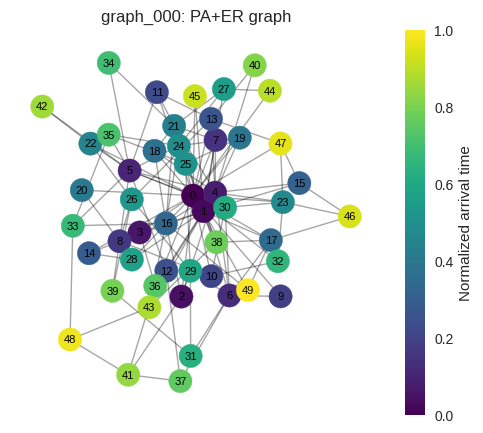

In [4]:
# Visualize a representative training graph colored by normalized arrival time
sample = train_data[0]
pos = nx.spring_layout(sample.graph, seed=SEED)
plt.figure(figsize=(6, 5))
# Draw nodes whose colors encode their true arrival timestamps
nodes = nx.draw_networkx_nodes(
    sample.graph, pos, node_color=sample.targets.numpy(), cmap="viridis", node_size=280
)
nx.draw_networkx_edges(sample.graph, pos, alpha=0.35)
# Label nodes so the ordering is easy to inspect manually
nx.draw_networkx_labels(sample.graph, pos, font_size=8)
cbar = plt.colorbar(nodes)
cbar.set_label("Normalized arrival time")
plt.title(f"{sample.name}: PA+ER graph")
plt.axis("off")
plt.show()


## Tiny Graph Attention Network

In [5]:
class GraphAttentionLayer(nn.Module):
    """Minimal multi-head graph attention layer with optional concatenation."""

    def __init__(self, in_dim: int, out_dim: int, heads: int = 1, dropout: float = 0.0, negative_slope: float = 0.2, concat: bool = True):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = nn.Dropout(dropout)  # Drop attention probabilities during training
        self.lin = nn.Linear(in_dim, out_dim * heads, bias=False)
        self.att_weight = nn.Parameter(torch.empty(heads, 2 * out_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin.weight)
        nn.init.xavier_uniform_(self.att_weight)

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        n = x.size(0)
        adj = adj.to(x.device)
        # Linear projection followed by per-head view
        h = self.lin(x).view(n, self.heads, self.out_dim)
        # Prepare pairwise node combinations for attention scoring
        h_i = h.unsqueeze(1).repeat(1, n, 1, 1)
        h_j = h.unsqueeze(0).repeat(n, 1, 1, 1)
        attn_input = torch.cat([h_i, h_j], dim=-1)
        # Shared attention weights compute compatibility per edge
        scores = torch.einsum("ijhd,hd->ijh", attn_input, self.att_weight)
        scores = F.leaky_relu(scores, negative_slope=self.negative_slope)
        mask = (adj > 0).unsqueeze(-1)
        scores = scores.masked_fill(~mask, float("-inf"))
        alpha = torch.softmax(scores, dim=1)
        alpha = self.dropout(alpha)
        alpha = alpha.permute(0, 2, 1)
        # Weighted sum of neighbor messages per head
        h_prime = torch.einsum("ihj,jhd->ihd", alpha, h)
        if self.concat:
            h_prime = h_prime.reshape(n, self.heads * self.out_dim)
        else:
            h_prime = h_prime.mean(dim=1)
        return h_prime


class TinyGATRegressor(nn.Module):
    """Two-layer GAT stack that regresses normalized arrival timestamps."""

    def __init__(self, in_dim: int, hidden_dim: int = 64, heads: int = 4, dropout: float = 0.2):
        super().__init__()
        self.dropout = dropout
        self.gat1 = GraphAttentionLayer(in_dim, hidden_dim, heads=heads, dropout=dropout, concat=True)
        self.gat2 = GraphAttentionLayer(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout, concat=False)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        # Apply attention layers with ELU activations and dropout regularization
        h = F.elu(self.gat1(x, adj))
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = F.elu(self.gat2(h, adj))
        return torch.sigmoid(self.out(h)).squeeze(-1)


## Training utilities

In [6]:
# Higher LOSS_DECAY emphasizes accurate ordering for the earliest nodes
LOSS_DECAY = 1.0  # Higher -> stronger emphasis on earliest nodes


def train_epoch(model: nn.Module, data: List[GraphSample], optimizer: torch.optim.Optimizer, device: torch.device = DEVICE) -> float:
    """Run one weighted-MSE training pass over all graphs in the split."""

    model.train()
    random.shuffle(data)
    total_loss = 0.0
    for sample in data:
        optimizer.zero_grad()
        preds = model(sample.features.to(device), sample.adjacency.to(device))
        targets = sample.targets.to(device)
        # Exponentially favor earlier timestamps inside the regression loss
        weights = torch.exp(-LOSS_DECAY * targets)
        weights = weights / (weights.mean() + 1e-8)
        mse = (preds - targets) ** 2
        loss = torch.mean(weights * mse)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(len(data), 1)


@torch.no_grad()
def evaluate(model: nn.Module, data: List[GraphSample], device: torch.device = DEVICE) -> dict:
    """Aggregate MAE plus Kendall/Spearman ranking metrics for a dataset split."""

    model.eval()
    maes, taus, rhos, mismatches = [], [], [], []
    for sample in data:
        preds = model(sample.features.to(device), sample.adjacency.to(device)).cpu().numpy()
        targets = sample.targets.numpy()
        maes.append(float(np.mean(np.abs(preds - targets))))
        tau_res = kendalltau(preds, targets)
        tau_val = getattr(tau_res, "correlation", tau_res[0]) if tau_res is not None else 0.0
        if tau_val is None or np.isnan(tau_val):
            tau_val = 0.0
        taus.append(float(tau_val))
        rho_res = spearmanr(preds, targets)
        rho_val = getattr(rho_res, "correlation", rho_res[0]) if rho_res is not None else 0.0
        if rho_val is None or np.isnan(rho_val):
            rho_val = 0.0
        rhos.append(float(rho_val))
        true_order = np.argsort(targets)[:5]
        pred_order = np.argsort(preds)[:5]
        mismatches.append(float(np.sum(pred_order != true_order)))
    return {
        "mae": float(np.mean(maes)) if maes else 0.0,
        "tau": float(np.mean(taus)) if taus else 0.0,
        "rho": float(np.mean(rhos)) if rhos else 0.0,
        "top5_perm_mismatch": float(np.mean(mismatches)) if mismatches else 0.0,
    }


## Train the GAT

In [7]:
# Initialize the regressor and optimizer before entering the training loop
model = TinyGATRegressor(in_dim=train_data[0].features.shape[1], hidden_dim=64, heads=4, dropout=0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)

EPOCHS = 200
history = {"train_loss": [], "val_mae": [], "val_tau": []}

# Train while monitoring the validation split for early diagnostics
for epoch in range(EPOCHS):
    loss = train_epoch(model, train_data, optimizer)
    val_stats = evaluate(model, val_data)
    history["train_loss"].append(loss)
    history["val_mae"].append(val_stats["mae"])
    history["val_tau"].append(val_stats["tau"])
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1:03d} | loss={loss:.4f} | val_mae={val_stats['mae']:.4f} | val_tau={val_stats['tau']:.3f}")


Epoch 001 | loss=0.0754 | val_mae=0.2414 | val_tau=0.225
Epoch 020 | loss=0.0649 | val_mae=0.2240 | val_tau=0.333
Epoch 040 | loss=0.0608 | val_mae=0.2190 | val_tau=0.355
Epoch 060 | loss=0.0595 | val_mae=0.2125 | val_tau=0.378
Epoch 080 | loss=0.0592 | val_mae=0.2181 | val_tau=0.360
Epoch 100 | loss=0.0577 | val_mae=0.2143 | val_tau=0.382
Epoch 120 | loss=0.0598 | val_mae=0.2202 | val_tau=0.384
Epoch 140 | loss=0.0592 | val_mae=0.2134 | val_tau=0.356
Epoch 160 | loss=0.0593 | val_mae=0.2115 | val_tau=0.385
Epoch 180 | loss=0.0587 | val_mae=0.2093 | val_tau=0.394
Epoch 200 | loss=0.0583 | val_mae=0.2110 | val_tau=0.376


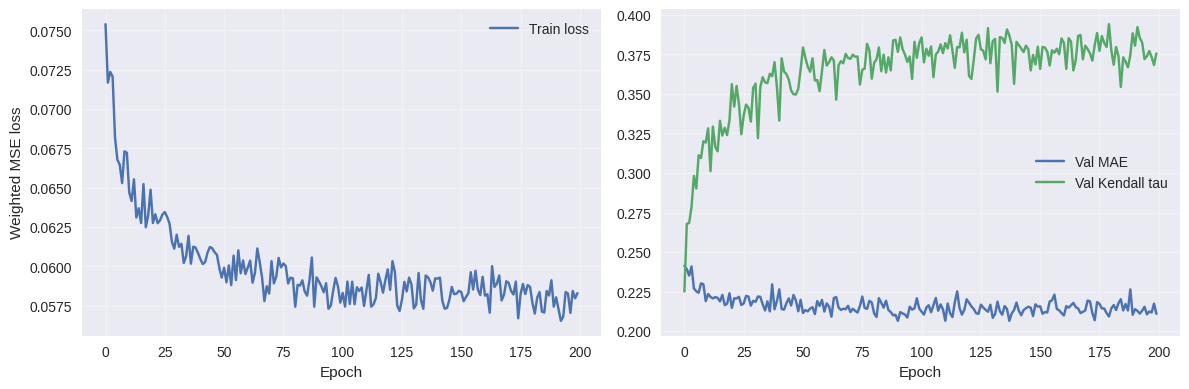

In [8]:
# Plot optimization curves to inspect convergence behavior quickly
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history["train_loss"], label="Train loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Weighted MSE loss")
axes[0].grid(alpha=0.3)
axes[0].legend()
axes[1].plot(history["val_mae"], label="Val MAE")
axes[1].plot(history["val_tau"], label="Val Kendall tau")
axes[1].set_xlabel("Epoch")
axes[1].grid(alpha=0.3)
axes[1].legend()
plt.tight_layout()
plt.show()


## Evaluate on held-out graphs

In [9]:
# Evaluate the final model on held-out graphs that were never seen during training
test_stats = evaluate(model, test_data)
print(f"Test MAE: {test_stats['mae']:.4f}")
print(f"Test Kendall tau: {test_stats['tau']:.3f}")
print(f"Test Spearman rho: {test_stats['rho']:.3f}")
print(f"Test top-5 permutation mismatch: {test_stats['top5_perm_mismatch']:.2f} positions")


Test MAE: 0.2193
Test Kendall tau: 0.362
Test Spearman rho: 0.514
Test top-5 permutation mismatch: 3.60 positions


### Ordering diagnostics for the first five test graphs

In [10]:
# Inspect ordering quality for a few individual held-out graphs
for sample in test_data[:5]:
    preds = model(sample.features.to(DEVICE), sample.adjacency.to(DEVICE)).detach().cpu().numpy()
    targets = sample.targets.numpy()
    tau_res = kendalltau(preds, targets)
    tau_val = getattr(tau_res, "correlation", tau_res[0]) if tau_res is not None else 0.0
    rho_res = spearmanr(preds, targets)
    rho_val = getattr(rho_res, "correlation", rho_res[0]) if rho_res is not None else 0.0
    mae = float(np.mean(np.abs(preds - targets)))
    # Compare predicted vs true earliest nodes to understand ordering mistakes
    true_order = np.argsort(targets)[:5]
    pred_order = np.argsort(preds)[:5]
    mismatch = int(np.sum(pred_order != true_order))
    print(f"{sample.name}: tau={tau_val:.3f}, rho={rho_val:.3f}, mae={mae:.4f}, top-5 mismatch={mismatch}/5")
    print(f"  true earliest nodes : {true_order}")
    print(f"  predicted earliest : {pred_order}")


graph_054: tau=0.301, rho=0.461, mae=0.2243, top-5 mismatch=3/5
  true earliest nodes : [0 1 2 3 4]
  predicted earliest : [ 0  9  2 19 15]
graph_055: tau=0.300, rho=0.428, mae=0.2368, top-5 mismatch=3/5
  true earliest nodes : [0 1 2 3 4]
  predicted earliest : [ 0  4  2 35 24]
graph_056: tau=0.391, rho=0.518, mae=0.2203, top-5 mismatch=4/5
  true earliest nodes : [0 1 2 3 4]
  predicted earliest : [ 3 31 44  0  4]
graph_057: tau=0.458, rho=0.631, mae=0.2099, top-5 mismatch=3/5
  true earliest nodes : [0 1 2 3 4]
  predicted earliest : [ 7  0  2 33  4]
graph_058: tau=0.347, rho=0.525, mae=0.2162, top-5 mismatch=4/5
  true earliest nodes : [0 1 2 3 4]
  predicted earliest : [7 5 2 4 3]


### Scatter plot for one held-out graph

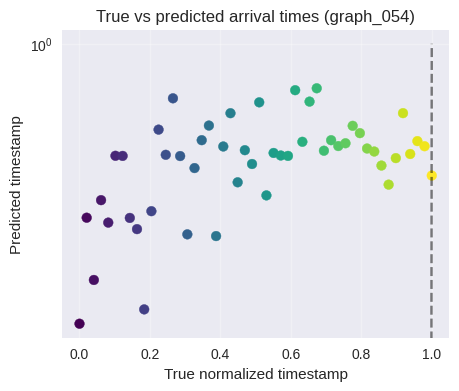

In [14]:
# Visual check of predicted vs. true timestamps for a single held-out graph
sample = test_data[0]
preds = model(sample.features.to(DEVICE), sample.adjacency.to(DEVICE)).detach().cpu().numpy()
targets = sample.targets.numpy()
plt.figure(figsize=(5, 4))
plt.scatter(targets, preds, c=targets, cmap="viridis")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("True normalized timestamp")
plt.ylabel("Predicted timestamp")
plt.yscale("log")
plt.title(f"True vs predicted arrival times ({sample.name})")
plt.grid(alpha=0.3)
plt.show()

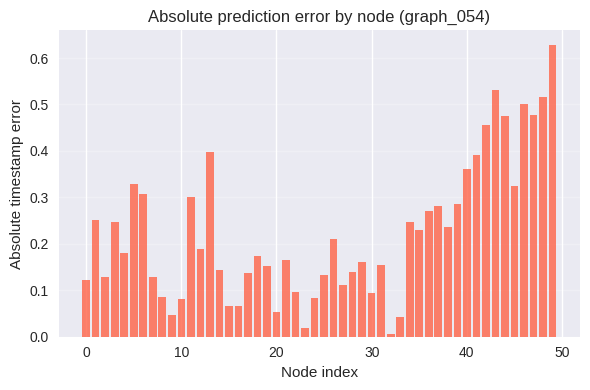

In [15]:
# Additional visualization: per-node absolute prediction error for the same held-out graph
sample = test_data[0]
preds = model(sample.features.to(DEVICE), sample.adjacency.to(DEVICE)).detach().cpu().numpy()
targets = sample.targets.numpy()
abs_err = np.abs(preds - targets)
plt.figure(figsize=(6, 4))
plt.bar(np.arange(len(abs_err)), abs_err, color="tomato", alpha=0.8)
plt.xlabel("Node index")
plt.ylabel("Absolute timestamp error")
plt.title(f"Absolute prediction error by node ({sample.name})")
plt.grid(alpha=0.25, axis="y")
plt.tight_layout()
plt.show()